## Final Project
In the final project we want to implement a custom training loop for a deep learning model in TensorFlow and Keras. The training loop should perform the following tasks:

1. Load the training and validation data.
2. Define the model architecture using Keras.
3. Compile the model with a loss function and an optimizer.
4. Train the model for a specified number of epochs, using a batch size of your choice.
5. Evaluate the model on the validation data after each epoch.
6. Plot the training and validation loss and accuracy curves using matplotlib.

**Assignment constraints:**

* You must use the TensorFlow 2.x API.
* You must use the Keras API to define the model architecture.
* You must use a custom training loop, rather than the `fit` method provided by Keras.
* You must use a GPU, if available, for training the model.

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## 1. Load the training and validation data
1.1. Use the TensorFlow Datasets to load the [Eurosat Dataset](https://www.tensorflow.org/datasets/catalog/eurosat).This dataset consist of satellite images from different types of zones\
You can check that this dataset has only one split `Train`. So create train/validation/test splits by using 70% of dataset as the train set, 15% for validation set and 15% for test set.

In [2]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'eurosat',
    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

2.2 Inspect dataset: extract number of classes in the dataset, class names, number of data in the dataset and use the `tfds` visualization tool to visualize some of the data

In [3]:
num_classes = metadata.features['label'].num_classes
get_label_name = metadata.features['label'].int2str
print(f"Number of classes in the dataset: {num_classes}")
for i in range(num_classes):
    print(f"class id {i} is {get_label_name(i)}")

Number of classes in the dataset: 10
class id 0 is AnnualCrop
class id 1 is Forest
class id 2 is HerbaceousVegetation
class id 3 is Highway
class id 4 is Industrial
class id 5 is Pasture
class id 6 is PermanentCrop
class id 7 is Residential
class id 8 is River
class id 9 is SeaLake


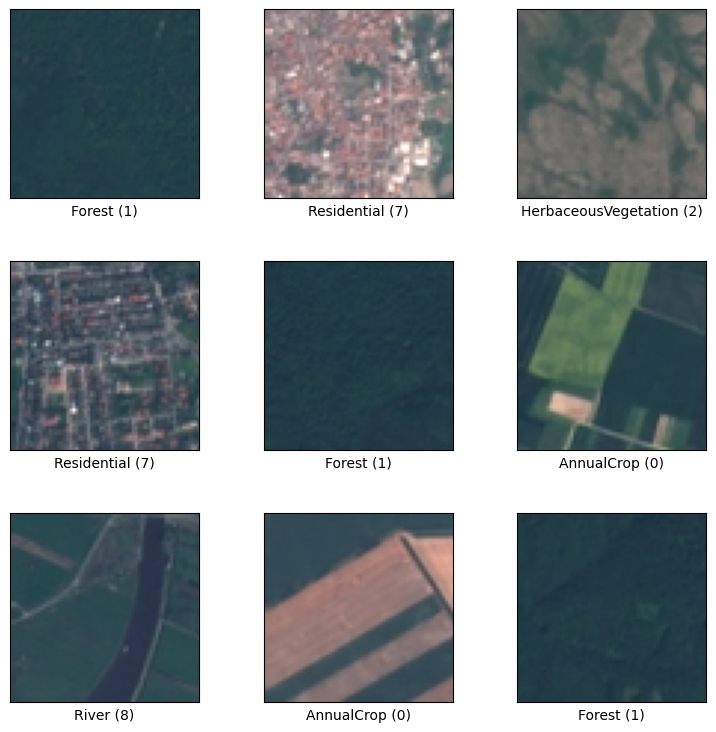

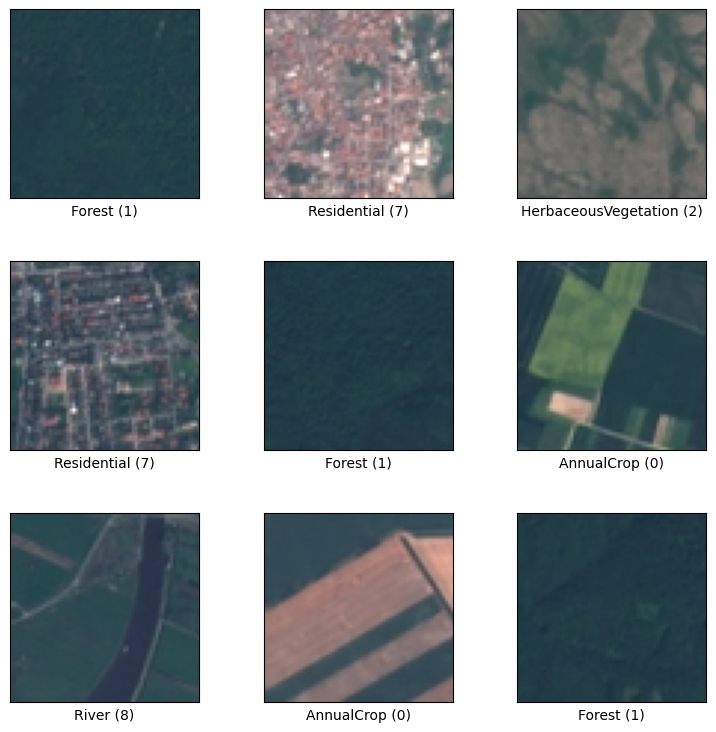

In [4]:
tfds.visualization.show_examples(
    train_ds,
    metadata
)

1.3. write a function that resize images to `64x64` and rescale the pixels to be between `[0,1]`. Also employ a one-hot encoding for the labels. Then by using `map` method apply this preprocessing function to all splits: (use num_parallel_calls argument in map function to run the function faster)

In [5]:
def preprocess(image, label):
    image = tf.image.resize(image, [64,64])
    image = tf.divide(image,255)
    encoded_label = tf.one_hot(label, 10)
    return image, encoded_label

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
val_ds   = val_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
test_ds  = test_ds.map(preprocess, num_parallel_calls=AUTOTUNE)

1.4. write several augmentation layer by your choice and apply it to training set

In [7]:
data_augmentation = data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.3),
  tf.keras.layers.RandomZoom(0.4)
])
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

1.5. Shuffle training data and batch all splits

In [8]:
batch_size = 16
buffer_size = 1000
train_ds = train_ds.shuffle(buffer_size)
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

1.6. Add cache and prefetch for optimizing the pipeline

In [9]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

## 2. Define the model architecture
implement following model with functional API:
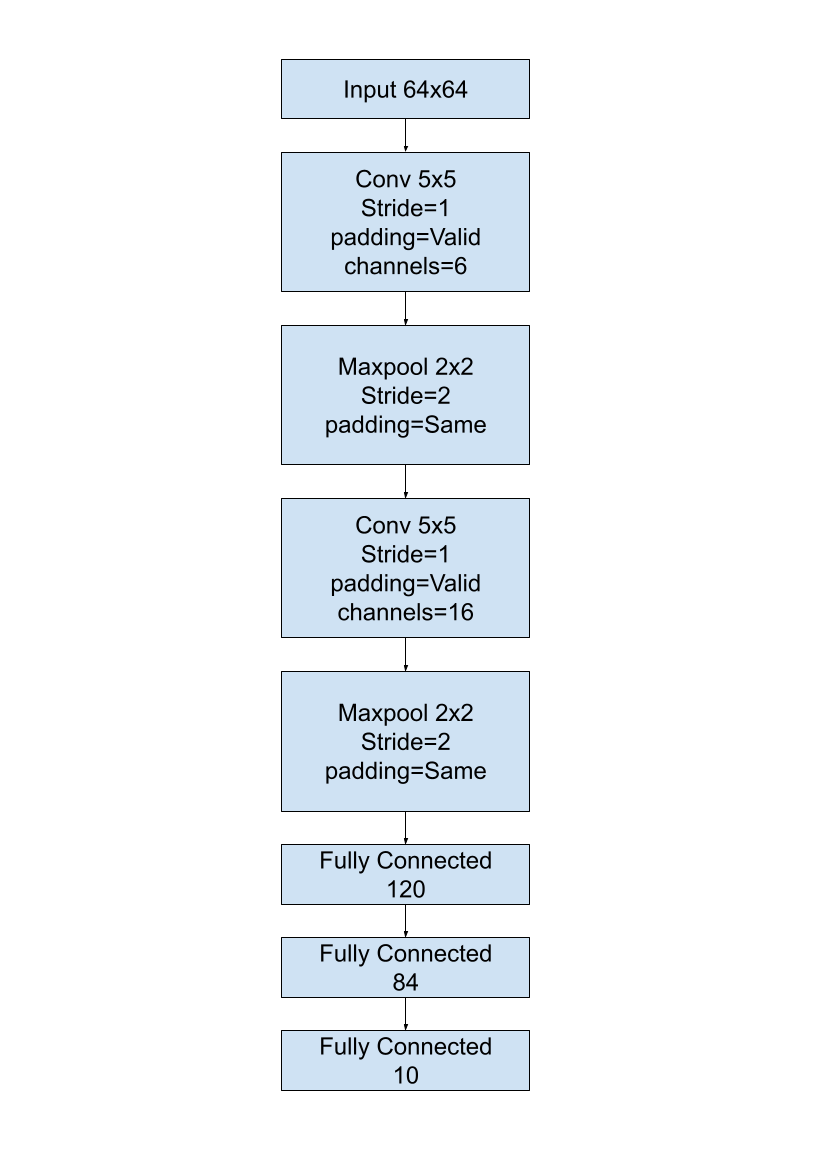

In [10]:
input_shape = (64, 64, 3)
num_classes = 10

input = tf.keras.Input(shape=input_shape)
x = tf.keras.layers.Conv2D(6, kernel_size=(5, 5), strides=1, padding = 'valid', name="first_conv")(input)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(x)
x = tf.keras.layers.Conv2D(16, kernel_size=(5, 5), strides=1, padding = 'valid', name="second_conv")(input)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(120, activation="relu")(x)
x = tf.keras.layers.Dense(84, activation="relu")(x)
pred = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs=input, outputs=pred)

## 3. Define the Loss Function, Optimizer and Metrics
define a categorical cross-entropy loss, an Adam optimizer and accuracy metric for training and validation.

In [11]:
optimizer = tf.keras.optimizers.RMSprop()
loss_fn = tf.keras.losses.CategoricalCrossentropy()

train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
val_acc_metric = tf.keras.metrics.CategoricalAccuracy()

## 4. Training Loop
Write a custom training and evaluation loop and store training and validation loss and training and validation accuracy of each epoch in a list:

In [12]:
# Define the number of epochs and the batch size
num_epochs = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
# Iterate over the number of epochs
for epoch in range(num_epochs):
    print('Start of epoch %d' % (epoch,))
    losses = []
    for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train)
            loss_value = loss_fn(y_true=y_batch_train, y_pred=logits)
        gradients = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))

        losses.append(loss_value)

        train_acc_metric(y_batch_train, logits)
        train_acc = train_acc_metric.result()
    losses_val = []
    for x_val, y_val in test_ds:
        val_logits = model(x_val)
        val_loss = loss_fn(y_true=y_val, y_pred=val_logits)
        losses_val.append(val_loss)
        val_acc_metric(y_val, val_logits)
    val_acc = val_acc_metric.result()

    losses_train_mean = np.mean(losses)
    losses_val_mean = np.mean(losses_val)
    val_losses.append(losses_val_mean)
    train_losses.append(losses_train_mean)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f' % (epoch, float(losses_train_mean), float(losses_val_mean), float(train_acc), float(val_acc)))

    train_acc_metric.reset_states()
    val_acc_metric.reset_states()

Start of epoch 0

 Epoch 0: Train loss: 1.7406  Validation Loss: 1.3115, Train Accuracy: 0.3659, Validation Accuracy 0.5020
Start of epoch 1

 Epoch 1: Train loss: 1.4170  Validation Loss: 1.1669, Train Accuracy: 0.4931, Validation Accuracy 0.5770
Start of epoch 2

 Epoch 2: Train loss: 1.2621  Validation Loss: 1.3985, Train Accuracy: 0.5493, Validation Accuracy 0.5040
Start of epoch 3

 Epoch 3: Train loss: 1.1974  Validation Loss: 1.1385, Train Accuracy: 0.5824, Validation Accuracy 0.6316
Start of epoch 4

 Epoch 4: Train loss: 1.1529  Validation Loss: 1.1296, Train Accuracy: 0.6003, Validation Accuracy 0.6242
Start of epoch 5

 Epoch 5: Train loss: 1.1384  Validation Loss: 1.1625, Train Accuracy: 0.6097, Validation Accuracy 0.6314
Start of epoch 6

 Epoch 6: Train loss: 1.0965  Validation Loss: 1.1369, Train Accuracy: 0.6274, Validation Accuracy 0.6170
Start of epoch 7

 Epoch 7: Train loss: 1.0954  Validation Loss: 1.1388, Train Accuracy: 0.6308, Validation Accuracy 0.6215
Start of

## 5. Plot the training and validation loss and accuracy curves using matplotlib.


In [13]:
def plot_loss_and_accuracy(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.plot(train_accuracies,color='blue')
    plt.plot(val_accuracies,color='green')
    plt.show(); plt.figure()
    plt.plot(train_losses,color='blue')
    plt.plot(val_losses,color='green')

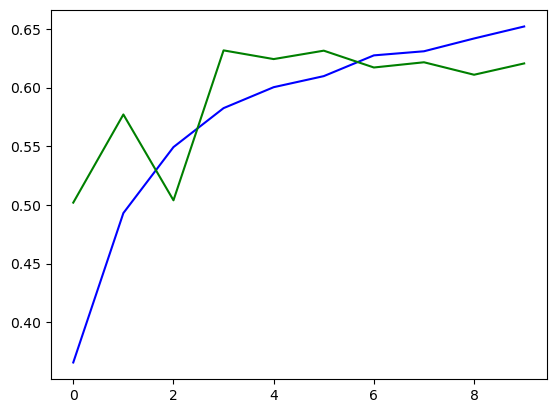

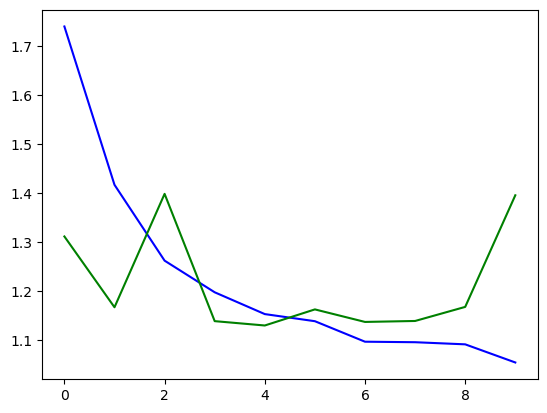

In [14]:
plot_loss_and_accuracy(train_losses, val_losses, train_accuracies, val_accuracies)